#  Классификация текстов с использованием эмбеддингов слов.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/text/stable/vocab.html
* https://pytorch.org/text/stable/transforms.html
* https://rusvectores.org/
* https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* https://github.com/natasha/navec
* https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
* https://torchmetrics.readthedocs.io/en/stable/

## Задачи для совместного разбора

1\. Реализуйте модель для классификации текстов с использованием слоя `nn.Embedding`. Заморозьте веса слоя эмбеддингов.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
X = th.randint(0, 1000, size=(16, 20)).long()
y = th.LongTensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding(
        num_embeddings=1000,
        embedding_dim=100,
    )
    self.fc = nn.Linear(in_features=100, out_features=2)

  def forward(self, X):
    # X: batch_size x seq_len
    e = self.emb(X) # batch_size x seq_len x emb_dim
    # преобразовать эмб. токенов в эмб. последовательности
    e = e.mean(dim=1) # batch_size x emb_dim
    out = self.fc(e) # batch_size x 2
    return out

In [ ]:
model = Net()
y_pred = model(X)
y_pred.shape

torch.Size([16, 2])

In [ ]:
model.emb.weight.requires_grad_(False)
model.emb.weight.requires_grad

False

2\. Используя `torchmetrics`, рассчитайте значение accuracy по эпохам с использованием мини-пакетного градиентого спуска.

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.9 MB/s eta 0:00:00


In [ ]:
import torchmetrics as M

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

dset = TensorDataset(X, y)
loader = DataLoader(dset, batch_size=4)

n_epochs = 5
lr = 0.001

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(n_epochs):
  preds, trues = [], []
  running_correct, running_count = 0, 0
  running_acc, running_steps = 0, 0

  acc_m = M.Accuracy(task="binary")

  for step, (X_b, y_b) in enumerate(loader):
    y_pred = model(X_b) # batch_size x n_classes
    loss = criterion(y_pred, y_b)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # v1
    preds.extend(list(y_pred.argmax(dim=1)))
    trues.extend(list(y_b))

    # v2
    running_correct += (y_pred.argmax(dim=1) == y_b).sum()
    running_count += len(y_b)

    # v3
    acc = (y_pred.argmax(dim=1) == y_b).float().mean()
    running_acc += acc
    running_steps += 1

    # v4
    acc_m.update(y_pred.argmax(dim=1), y_b)

    print(f"{epoch=} {step=} {acc.item()=}")

  preds = th.tensor(preds)
  trues = th.tensor(trues)
  acc_epochs = (preds == trues).float().mean()
  acc_epochs2 = running_correct / running_count
  acc_epochs3 = running_acc / running_steps
  acc_epochs4 = acc_m.compute()
  print(f"{epoch=} "
        f"{acc_epochs.item()=} \n"
        f"{acc_epochs2.item()=} \n"
        f"{acc_epochs3.item()=} \n"
        f"{acc_epochs4.item()=}"
  )

epoch=0 step=0 acc.item()=0.5
epoch=0 step=1 acc.item()=0.75
epoch=0 step=2 acc.item()=0.0
epoch=0 step=3 acc.item()=0.5
epoch=0 acc_epochs.item()=0.4375 
acc_epochs2.item()=0.4375 
acc_epochs3.item()=0.4375 
acc_epochs4.item()=0.4375
epoch=1 step=0 acc.item()=0.5
epoch=1 step=1 acc.item()=0.75
epoch=1 step=2 acc.item()=0.0
epoch=1 step=3 acc.item()=0.5
epoch=1 acc_epochs.item()=0.4375 
acc_epochs2.item()=0.4375 
acc_epochs3.item()=0.4375 
acc_epochs4.item()=0.4375
epoch=2 step=0 acc.item()=0.75
epoch=2 step=1 acc.item()=0.75
epoch=2 step=2 acc.item()=0.0
epoch=2 step=3 acc.item()=0.75
epoch=2 acc_epochs.item()=0.5625 
acc_epochs2.item()=0.5625 
acc_epochs3.item()=0.5625 
acc_epochs4.item()=0.5625
epoch=3 step=0 acc.item()=0.75
epoch=3 step=1 acc.item()=0.75
epoch=3 step=2 acc.item()=0.0
epoch=3 step=3 acc.item()=0.75
epoch=3 acc_epochs.item()=0.5625 
acc_epochs2.item()=0.5625 
acc_epochs3.item()=0.5625 
acc_epochs4.item()=0.5625
epoch=4 step=0 acc.item()=0.75
epoch=4 step=1 acc.item()

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Считайте файл `lenta_news.csv` и разбейте на обучающую и тестовую выборку. Выполните предобработку текста и создайте Vocab на основе обучающей выборки (токен - слово). Выведите на экран количество токенов в полученном словаре.

- [x] Проверено на семинаре

In [1]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 64.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=f8cdd1232366f1cfdd995cdaa9cc84ae960cb95bc38c67648958ee7219e4751e
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [4]:
import pandas as pd
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
import nltk

nltk.download('stopwords')
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [6]:
stop_words = set(stopwords.words('russian'))
df = pd.read_csv('lenta_news.csv')['text']
label = pd.read_csv('lenta_news.csv')['topic']

tokenizer = RegexpTokenizer(r'[а-яё]+')
corpus = df.apply(lambda x: [morph.parse(word)[0].normal_form for word in tokenizer.tokenize(x.lower()) if word not in stop_words])

In [102]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
y = LE.fit_transform(label)
LE.classes_

array(['Интернет и СМИ', 'Культура', 'Спорт', 'Экономика'], dtype=object)

In [9]:
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2)

In [11]:
corpus_train

7617     [интернет, входить, третий, прагматический, фа...
16906    [состояться, жеребьёвка, первый, раунд, розыгр...
12355    [российский, теннисистка, надежда, петров, вый...
20122    [ноябрь, московский, музей, кино, красный, пре...
464      [выступить, март, многотысячный, коллектив, за...
                               ...                        
3173     [февраль, совещание, представитель, аудитор, э...
4008     [председатель, правление, некоммерческий, парт...
11433    [минпечати, направить, телекомпания, нтв, пред...
10609    [допрос, владимир, гусинский, среда, проводить...
2383     [объём, финансовый, резерв, октябрь, год, сост...
Name: text, Length: 19159, dtype: object

In [85]:
vcb = build_vocab_from_iterator(corpus_train, specials=["<pad>", "<unk>"])
vcb.set_default_index(vcb['<unk>'])

In [86]:
len(vcb) # без предобработки len(vcb) = 220378

67202

<p class="task" id="2"></p>


2\. Создайте класс `NewsDataset`. Реализуйте метод `__getitem__` таким образом, чтобы он возвращал набор индексов токенов для текста новости (или новостей, если используются срезы) и метки классов для этих новостей. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами). Закодируйте целыми числами категории новостей. Создайте два объекта класса `NewsDataset` (для обучающей и тестовой выборки).

Выведите на экран результат выполнения `train_dataset[0]` и `train_dataset[:3]`

- [ ] Проверено на семинаре

In [87]:
import torch as th
from torch.utils.data import Dataset

In [89]:
corpus.apply(lambda x: len(x)).mean()

122.38385736356425

In [90]:
class TransformEqLen:
  def __init__(self, seq_length, pad_id):
    self.seq_length = seq_length
    self.pad_id = pad_id

  def __call__(self, sents):
    sents_ = sents.copy()
    for i in range(len(sents)):
      if len(sents[i]) > self.seq_length:
          sents_[i] = sents[i][:self.seq_length]
      else:
          sents_[i] += [self.pad_id] * (self.seq_length - len(sents[i]))
    return sents_

In [91]:
class NewsDataset(Dataset):
  def __init__(self, data, labels, vocab, transform):
    self.data = data.values
    self.labels = labels
    self.vocab = vocab
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    texts = self.data[index]
    labels = self.labels[index]

    if isinstance(index, int):
      texts = [texts]
    sents = [[self.vocab[token] for token in text] for text in texts]
    sents_ = self.transform(sents)

    return th.tensor(sents_), th.tensor(labels)

In [92]:
pad_id = vcb['<pad>']
seq_length = 150
transform = TransformEqLen(seq_length, pad_id)

train_dataset = NewsDataset(corpus_train, y_train, vcb, transform)
test_dataset = NewsDataset(corpus_test, y_test, vcb, transform)
train_dataset[0], test_dataset[0]

((tensor([[   38,   681,   102, 57521,  8644,   213,    19,  1879,  1631,  2129,
             313,   479,   223,     5,   457,  1775,  3720,     3,   150,   218,
           37814,    99,  2129,     8,  2576,   213,    38,   298,     2,   744,
             367,     5,   873,     4,  2494,    38,     2,   298,    36,  2576,
              13,     3,     5,  3718,  1609,  3017,  1286,   538,    38,  4178,
             833,   411,    99,  2129,  1892,   102,  2576,  1501,  2254,  1627,
             379,  1509,    31,  1093,   817,   479,     3,  1571,  1458,   442,
              38,   107,    10,    13,   102,  2576,  2781, 12838,  4315,    38,
               3,   256,  1458,  5494,  4696,   171,     5,     5,   796,    14,
               5,   266,    99,  2129,   677,   171,    10,  9697,   213,  4085,
            1553,  1715,    38,   532,    99,  2129,   635,  1921,     3,   153,
            1985,  1792,   253,   698,    38,   195,    24,   402, 17647,   165,
            7671, 36125,    

In [93]:
train_dataset[:3]

(tensor([[   38,   681,   102, 57521,  8644,   213,    19,  1879,  1631,  2129,
            313,   479,   223,     5,   457,  1775,  3720,     3,   150,   218,
          37814,    99,  2129,     8,  2576,   213,    38,   298,     2,   744,
            367,     5,   873,     4,  2494,    38,     2,   298,    36,  2576,
             13,     3,     5,  3718,  1609,  3017,  1286,   538,    38,  4178,
            833,   411,    99,  2129,  1892,   102,  2576,  1501,  2254,  1627,
            379,  1509,    31,  1093,   817,   479,     3,  1571,  1458,   442,
             38,   107,    10,    13,   102,  2576,  2781, 12838,  4315,    38,
              3,   256,  1458,  5494,  4696,   171,     5,     5,   796,    14,
              5,   266,    99,  2129,   677,   171,    10,  9697,   213,  4085,
           1553,  1715,    38,   532,    99,  2129,   635,  1921,     3,   153,
           1985,  1792,   253,   698,    38,   195,    24,   402, 17647,   165,
           7671, 36125,    73,   322,  1

<p class="task" id="3"></p>

3\. Реализуйте модель, которая получает на вход батч новостей (в виде индексов токенов), пропускает его через слой `nn.Embedding` (матрица эмбеддингов инициализируется случайным образом), после чего передает полученные эмбеддинги части-классификатору (который состоит из некоторого количества полносвязных слоев). Для получения эмбеддинга для предложения на основе эмбеддингов слов воспользуйтесь любой функцией агрегации, сохраняющей размерности векторов (сумма, усреднение и т.д.).

Решите задачу классификации новостей. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики f1 на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран отчет по классификации на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [96]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.5 MB/s eta 0:00:00


In [98]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchmetrics as M
from torch.utils.data import TensorDataset, DataLoader

In [147]:
class NewsClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
    super(NewsClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.fc = nn.Sequential(
        nn.Linear(embedding_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, num_classes)
    )

  def forward(self, x):
    embedded = self.embedding(x)
    aggregated = embedded.mean(dim=1)
    output = self.fc(aggregated)
    return output

In [152]:
n_epochs = 15
lr = 0.01
batch_size = 5000
vocab_size = len(train_dataset.vocab)
embedding_dim = 100
hidden_dim = 150
num_classes = len(LE.classes_)

model = NewsClassifier(vocab_size, embedding_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
train_f1_scores = []
test_f1_scores = []

for epoch in range(n_epochs):
  F1_train = M.F1Score(task="multiclass", num_classes=num_classes)
  train_loss = 0
  for X_b, y_b in train_loader:
    y_pred = model(X_b) # batch_size x n_classes
    loss = criterion(y_pred, th.eye(4).long()[y_b])
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    F1_train.update(y_pred.argmax(dim=1).float(), y_b)

  train_losses.append(train_loss)
  train_f1_scores.append(F1_train.compute())

  F1_test = M.F1Score(task="multiclass", num_classes=num_classes)
  for X_b, y_b in test_loader:
    y_pred = model(X_b)
    F1_test.update(y_pred.argmax(dim=1).float(), y_b)

  test_f1_scores.append(F1_test.compute())

Затраченное время: 5мин. 19с.

In [155]:
import matplotlib.pyplot as plt

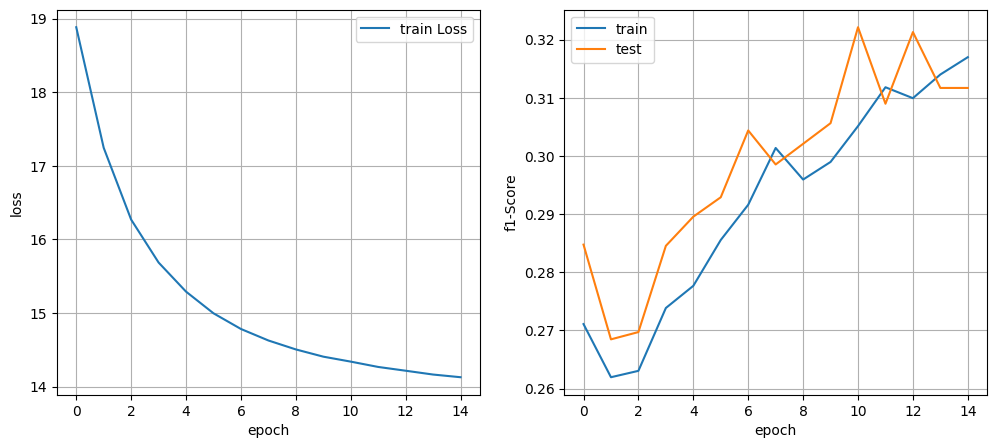

In [160]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='train')
plt.plot(test_f1_scores, label='test')
plt.xlabel('epoch')
plt.ylabel('f1-Score')
plt.legend()
plt.grid()

<p class="task" id="4"></p>

4\. Повторите решение задачи 3, создав слой `nn.Embedding` на основе предобученных векторов для слов русского языка и заморозив веса данного слоя. Для поиска векторов можете воспользоваться любым известным вам ресурсом. Сравните качество полученного решения и решения из предыдущей задачи, а также время, затраченное на обучения моделей.  

- [ ] Проверено на семинаре

In [162]:
!pip install navec

In [167]:
!pip install slovnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.4 MB/s eta 0:00:00


In [242]:
from navec import Navec
from slovnet.model.emb import NavecEmbedding

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
emb = NavecEmbedding(navec)

In [213]:
class NewsDataset(Dataset):
  def __init__(self, data, labels, vocab, transform):
    self.data = data.values
    self.labels = labels
    self.vocab = vocab
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    texts = self.data[index]
    labels = self.labels[index]

    if isinstance(index, int):
      texts = [texts]
    sents = [[self.vocab.get(token, self.vocab['<unk>']) for token in text] for text in texts]
    sents_ = self.transform(sents)

    return th.tensor(sents_), th.tensor(labels)

In [214]:
pad_id = navec.vocab['<pad>']
seq_length = 150
transform = TransformEqLen(seq_length, pad_id)

train_dataset4 = NewsDataset(corpus_train, y_train, navec.vocab, transform)
test_dataset4 = NewsDataset(corpus_test, y_test, navec.vocab, transform)
train_dataset4[0], test_dataset4[0]

((tensor([[ 82720,  44593, 220918, 166987, 230313, 181592,  76562, 142050,  28157,
            50069, 104678,  27943, 191591,  94129, 240113,  67729, 193386,  97802,
           175800, 208882, 250000, 115658,  50069, 150062,  41740, 181592,  82720,
           124578,  52287, 142075, 237897,  94129, 133219, 195976, 173007,  82720,
            52287, 124578,  44377,  41740,  43546,  97802,  94129, 172282, 140496,
            35258,  59204, 139467,  82720,  76287, 185806,  65530, 115658,  50069,
           124607, 220918,  41740, 142068,  51861, 150332, 245251, 238568, 114902,
           162157, 170050,  27943,  97802,  36632, 242989,  84363,  82720, 196149,
           247866,  43546, 220918,  41740, 181552, 198029, 141008,  82720,  97802,
           168421, 242989, 207390,  82583, 144591,  94129,  94129,  91623, 215107,
            94129, 206475, 115658,  50069, 217858, 144591, 247866,  46132, 181592,
           182691, 228868, 116118,  82720,  65406, 115658,  50069, 115685, 233979,
    

In [286]:
class NewsClassifierNavecEmb(nn.Module):
  def __init__(self, emb, hidden_dim=150, num_classes=4, req_grad=False):
    super(NewsClassifierNavecEmb, self).__init__()
    self.embedding = emb
    self.embedding.codes.requires_grad_(req_grad)
    self.embedding_dim = self.embedding.dim
    self.fc = nn.Sequential(
        nn.Linear(self.embedding_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, num_classes)
    )

  def forward(self, x):
    embedded = self.embedding(x)
    aggregated = embedded.mean(dim=1)
    output = self.fc(aggregated)
    return output

In [256]:
%%time
n_epochs = 10
lr = 0.01
batch_size = 5000
hidden_dim = 150
num_classes = len(LE.classes_)

model = NewsClassifierNavecEmb(emb, hidden_dim, num_classes, req_grad=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(train_dataset4, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset4, batch_size=batch_size, shuffle=False)

train_losses = []
train_f1_scores = []
test_f1_scores = []

for epoch in range(n_epochs):
  F1_train = M.F1Score(task="multiclass", num_classes=num_classes)
  train_loss = 0
  for X_b, y_b in train_loader:
    y_pred = model(X_b) # batch_size x n_classes
    loss = criterion(y_pred, th.eye(4).long()[y_b])
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    F1_train.update(y_pred.argmax(dim=1).float(), y_b)

  train_losses.append(train_loss)
  train_f1_scores.append(F1_train.compute())

  F1_test = M.F1Score(task="multiclass", num_classes=num_classes)
  for X_b, y_b in test_loader:
    y_pred = model(X_b)
    F1_test.update(y_pred.argmax(dim=1).float(), y_b)

  test_f1_scores.append(F1_test.compute())

CPU times: user 9min 37s, sys: 2min 9s, total: 11min 47s
Wall time: 11min 48s


In [255]:
train_losses

[18.66928720474243, 17.053826332092285, 16.62458848953247]

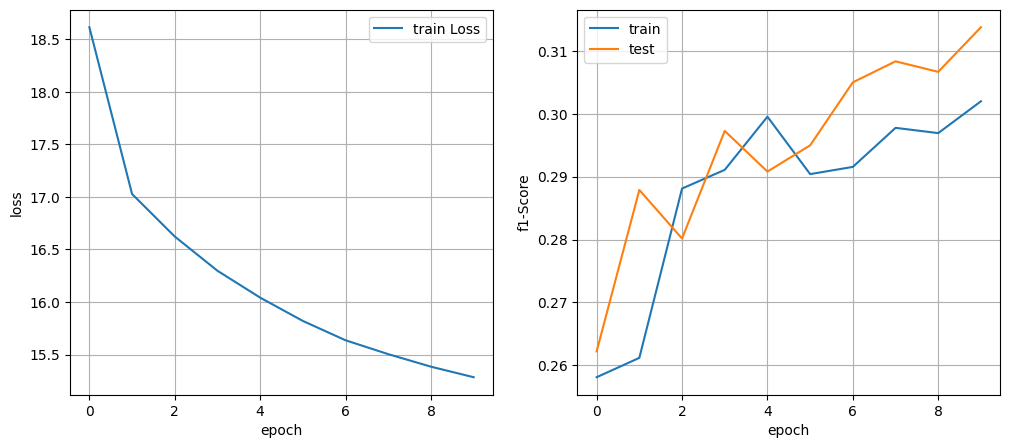

In [257]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='train')
plt.plot(test_f1_scores, label='test')
plt.xlabel('epoch')
plt.ylabel('f1-Score')
plt.legend()
plt.grid()

Несмотря на то, что прошлая модель обучалась на 15 эпохах, а эта на 10, данная модель обучалась в ~2 раза дольше.

Качество модели не изменилось: f1-score в районе 0.3

<p class="task" id="5"></p>

5\. Повторите решение задачи 3, не замораживая веса слоя эмбеддингов. Сравните качество полученного решения и решений из предыдущих задач, а также время, затраченное на обучения моделей.  

- [ ] Проверено на семинаре

In [287]:
from navec import Navec
from slovnet.model.emb import NavecEmbedding

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
emb = NavecEmbedding(navec)

In [290]:
%%time
n_epochs = 5
lr = 0.01
batch_size = 5000
hidden_dim = 150
num_classes = len(LE.classes_)

model = NewsClassifierNavecEmb(emb, hidden_dim, num_classes, req_grad=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(train_dataset4, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset4, batch_size=batch_size, shuffle=False)

train_losses = []
train_f1_scores = []
test_f1_scores = []

for epoch in range(n_epochs):
  F1_train = M.F1Score(task="multiclass", num_classes=num_classes)
  train_loss = 0
  for X_b, y_b in train_loader:
    y_pred = model(X_b) # batch_size x n_classes
    loss = criterion(y_pred, th.eye(4).long()[y_b])
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    F1_train.update(y_pred.argmax(dim=1).float(), y_b)

  train_losses.append(train_loss)
  train_f1_scores.append(F1_train.compute())

  F1_test = M.F1Score(task="multiclass", num_classes=num_classes)
  for X_b, y_b in test_loader:
    y_pred = model(X_b)
    F1_test.update(y_pred.argmax(dim=1).float(), y_b)

  test_f1_scores.append(F1_test.compute())

CPU times: user 5min 39s, sys: 1min 20s, total: 6min 59s
Wall time: 7min 1s


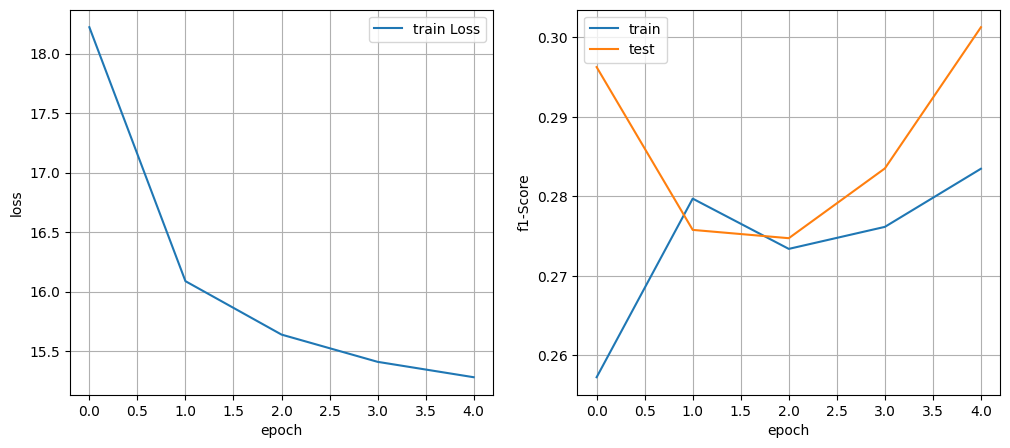

In [291]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='train')
plt.plot(test_f1_scores, label='test')
plt.xlabel('epoch')
plt.ylabel('f1-Score')
plt.legend()
plt.grid()

Данная модель обучалась на 5 эпохах, первая на 15, однако данная модель обучалась на 2 мин. дольше.

Качество модели на тесте не изменилось: f1-score в районе 0.3

<p class="task" id="6"></p>

6\. Воспользовавшись обученной моделью из предыдущей задачи, визуализируйте эмбеддинги новостей из тестовой выборки в двумерном пространстве. Для проекции точек в двумерное пространство воспользуйтесь алгоритмом t-SNE. Раскрасьте точки в цвет, соответствующий классу новости.

- [ ] Проверено на семинаре

In [320]:
from sklearn.manifold import TSNE

In [334]:
X_for_tsne, y_for_tsne = test_dataset4[:]
X_for_tsne_news = model.embedding(X_for_tsne).mean(dim=1)
X_after_tsne = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=3).fit_transform(X_for_tsne_news)

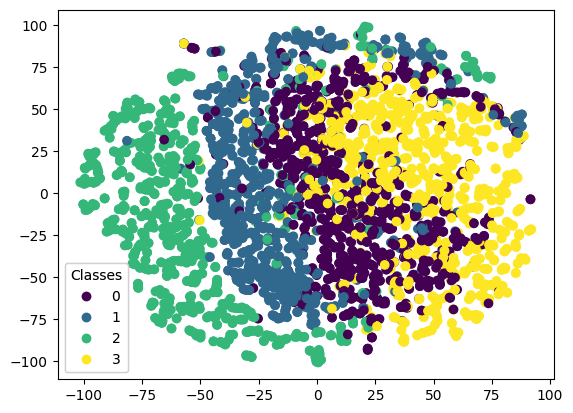

In [367]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_after_tsne[:,0], X_after_tsne[:,1], c=y_for_tsne)

legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.show()

## Обратная связь
- [x] Хочу получить обратную связь по решению